# Bank Customer Churn

In [326]:
#Database
import mysql.connector
from mysql.connector import connect
from getpass import getpass

In [280]:
# custom functions
import functions as ff

In [281]:
import pandas as pd
import numpy as np
from datetime import date
import scipy.special
import scipy.stats as stats
import math as m
from collections import Counter

In [282]:
# Viz
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [283]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [284]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso

In [285]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [286]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [287]:
import warnings
warnings.filterwarnings('ignore') # no more warnings 

In [288]:
pd.set_option('display.max_columns', None)

# Metadata

> *  Customer ID - Unique ID given to identify a particular customer.
> *  Credit Score - It is the score which determines the creditworthiness of a customer.
> *  Country - The country where customer lives.
> *  Gender - The Sex of customer.
> *  Age - The age of customer.
> *  Tenure - Number of years the customer has Bank Account in that Bank.
> *  Balance - Amount of money present in customer's bank.
> *  Products Number - Number of Products from that Bank.
> *  Credit Card - Does the customer own a credit card of that Bank.
> *  Active Member - Whether the customer is an active member of that Bank.
> *  Estimated Salary - Total Income of the Customer.
> *  Churn - Churn (Loss of existing customers) of the Bank.

# Getting the data

####  Connecting to database

In [337]:
db = connect(
        host= "localhost",
        user = "root",
        passwd = getpass("Enter password: "),
        database= "project"
   )

Enter password: ········


In [338]:
cursor = db.cursor()

In [339]:
#defining the query
query = "select a.customer_id, a.credit_score, ct.country, c.gender, c.age, a.tenure, a.balance, a.products_number, a.credit_card, a.active_member, a.estimated_salary, a.churn from account a join customer c on a.customer_id = c.customer_id join country ct on a.country_id = ct.country_id"

In [340]:
cursor.execute(query)

In [341]:
df=cursor.fetchall()

In [342]:
df = pd.read_sql_query(query,db)
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15565701,698,Spain,Female,39,9,161993.89,1,0,0,90212.38,0
1,15565706,612,Spain,Male,35,1,0.00,1,1,1,83256.26,1
2,15565878,631,Spain,Male,29,3,0.00,2,1,1,197963.46,0
3,15566091,545,Spain,Female,32,4,0.00,1,1,0,94739.20,0
4,15566292,574,Spain,Male,36,1,0.00,2,0,1,71709.12,0


#### Reading the file

In [337]:
#df = pd.read_csv("../data/Bank Customer Churn Prediction.csv", sep = ',')
#df.head()

In [338]:
# we drop "customer_id" as it isn't relevant for our analysis
df.drop('customer_id', inplace=True, axis=1)
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Understanding the dataset

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


Number of churn by age

In [292]:
query_age = "select case when c.age between 0 and 12 then 'children' when c.age between 13 and 18 then 'teenagers' when c.age between 19 and 35 then 'younger adults' when c.age between 36 and 65 then 'adults' when c.age > 65 then 'older adults' end as age_period , case when c.age between 0 and 12 then '0-12' when c.age between 13 and 18 then '13-18' when c.age between 19 and 35 then '19-35' when c.age between 36 and 65 then '36-65' when c.age > 65 then '65+' end as age_range, count(a.churn) as nbr_churn_age from customer c join account a on c.customer_id = a.customer_id where a.churn = 1 group by age_period, age_range order by age_range asc"

In [347]:
cursor.execute(query_age)

In [348]:
records = cursor.fetchall()

In [349]:
age_df = pd.read_sql_query(query_age,db)
age_df.head()

,age_period,age_range,nbr_churn_age
0,teenagers,13-18,2
1,younger adults,19-35,345
2,adults,36-65,1655
3,older adults,65+,35


Number of churn by country

In [350]:
query_country = "select c.country, count(a.churn) as nbr_churn_country from account a join country c on a.country_id = c.country_id where a.churn = 1 group by c.country"

In [351]:
cursor.execute(query_country)

In [352]:
records = cursor.fetchall()

In [353]:
country_df = pd.read_sql_query(query_country,db)
country_df.head()

,country,nbr_churn_country
0,Spain,413
1,France,810
2,Germany,814


#### The columns that are numerical:

In [340]:
numericals=df.select_dtypes(include=np.number)
numericals

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,42,2,0.00,1,1,1,101348.88,1
1,608,41,1,83807.86,1,0,1,112542.58,0
2,502,42,8,159660.80,3,1,0,113931.57,1
3,699,39,1,0.00,2,0,0,93826.63,0
4,850,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0
9996,516,35,10,57369.61,1,1,1,101699.77,0
9997,709,36,7,0.00,1,0,1,42085.58,1
9998,772,42,3,75075.31,2,1,0,92888.52,1


#### The columns that are categorical:

In [341]:
categoricals=df.select_dtypes(include=np.object)
categoricals

,country,gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female
...,...,...
9995,France,Male
9996,France,Male
9997,France,Female
9998,Germany,Male


## 2. Data Cleaning

#### Checking and dealing with Nan values:

In [342]:
df.isna().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

> There are not null values

#### standarize labels

In [343]:
df = ff.stand_col_labels(df)

> we use a custom function to standarize labels (Although, this dataset already has the column names standardized)

#### Check for duplicates

In [344]:
df.shape

(10000, 11)

In [345]:
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
df.shape

(10000, 11)

> There are not duplicates

## 3. Explory Data Analysis

In [346]:
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


> we include more statistic information

In [347]:
df.agg(['mean','median','std', lambda x: x.quantile(0.75) - x.quantile(0.25), 'skew','kurt','size','max','min','shape'])

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
mean,650.5288,NaN,NaN,38.9218,5.0128,76485.889288,1.5302,0.7055,0.5151,100090.239881,0.2037
median,652.0,NaN,NaN,37.0,5.0,97198.54,1.0,1.0,1.0,100193.915,0.0
std,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
<lambda>,134.0,NaN,NaN,12.0,4.0,127644.24,1.0,1.0,1.0,98386.1375,0.0
skew,-0.071607,NaN,NaN,1.01132,0.010991,-0.141109,0.745568,-0.901812,-0.060437,0.002085,1.471611
kurt,-0.425726,NaN,NaN,1.395347,-1.165225,-1.489412,0.582981,-1.186973,-1.996747,-1.181518,0.165671
size,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
max,850,Spain,Male,92,10,250898.09,4,1,1,199992.48,1
min,350,France,Female,18,0,0.0,1,0,0,11.58,0
shape,"(10000,)","(10000,)","(10000,)","(10000,)","(10000,)","(10000,)","(10000,)","(10000,)","(10000,)","(10000,)","(10000,)"


#### Visualize Distributions

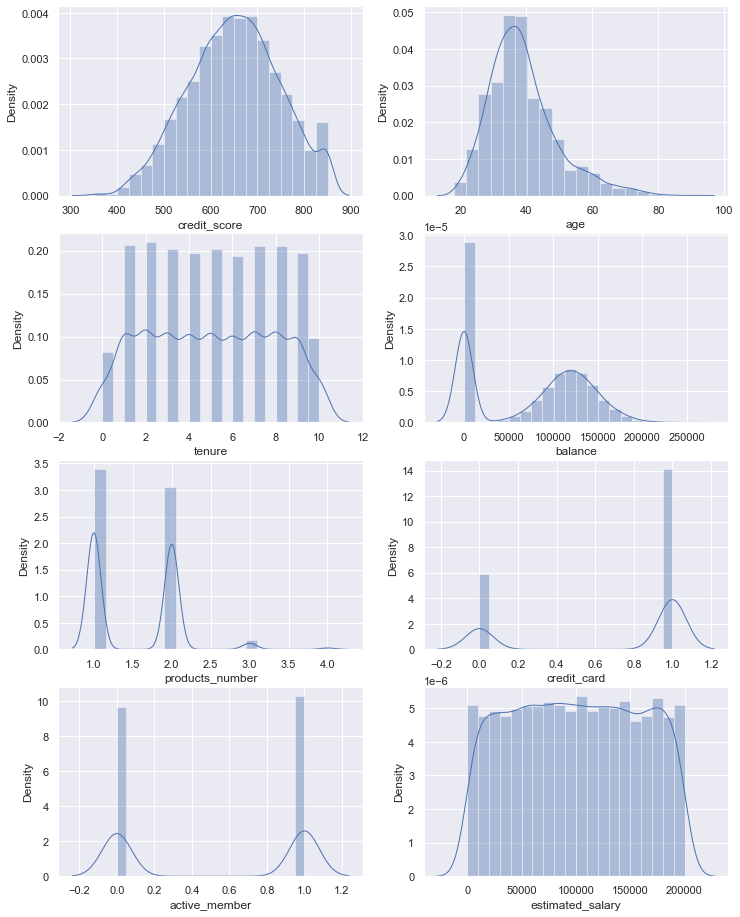

In [348]:
fig, axs = plt.subplots(4, 2, figsize = (12, 16))
for i in range(4):
    for j in range(2):
        curr_column = numericals.columns[(i*2) + j]
        sns.distplot(numericals[curr_column],
        hist=True, 
        kde=True,
        ax=axs[i,j], 
        bins=20, 
        kde_kws={'linewidth': 1})

> In terms of distribution, at the moment we don't have a completely normal distribution in any of the graphs above. Age, Credit_Score and Balance are somewhat normal. 

### Bivariate Analysis

#### Continous Variable

Text(0.5, 1.0, 'Age Feature Show slight significance churn = 1 within age groups 50-60')

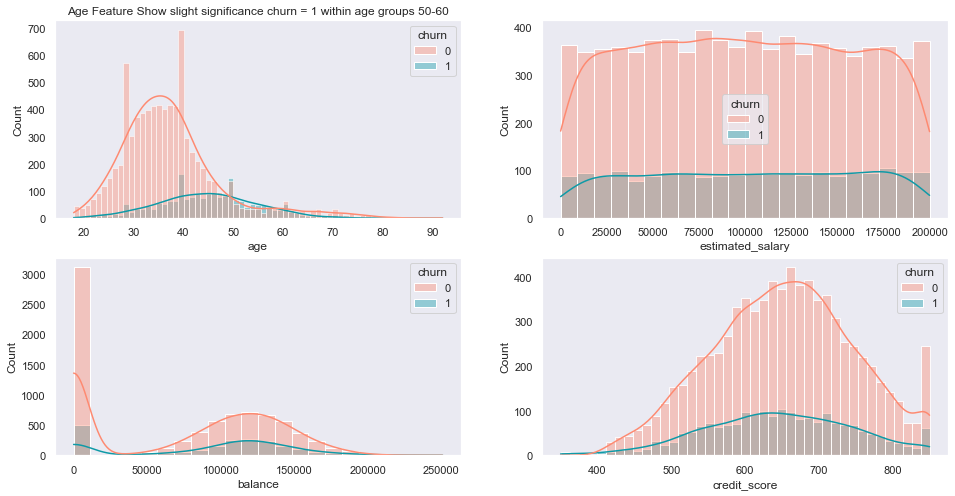

In [350]:
colors = ["#fe8a71", "#0e9aa7"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))
fig_continous_var,axes = plt.subplots(2,2,figsize=(16,8))
continous_vars =['age','estimated_salary','balance','credit_score']
for col,ax in zip(continous_vars,axes.ravel()) : 
    ax.grid()
    sns.histplot(df,x=col,kde=True,hue='churn',alpha= 0.4,ax=ax)
axes[0][0].set_title(
    'Age Feature Show slight significance churn = 1 within age groups 50-60'
)

#### Exploring categoricals

In [351]:
categoricals_features = ['country', 'gender', 'products_number', 'credit_card', 'active_member', 'churn']

<AxesSubplot: xlabel='churn', ylabel='count'>

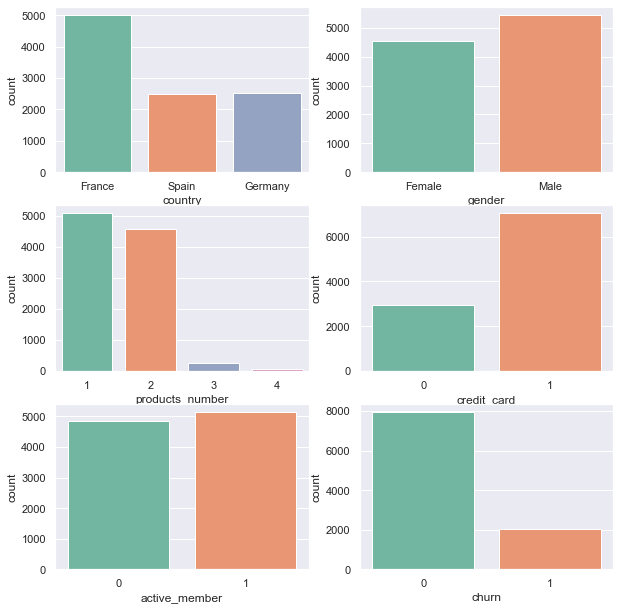

In [352]:
plt.figure(figsize = (10,14))
plt.subplot(4,2,1)
sns.countplot(x = 'country', palette='Set2', data = df)
plt.subplot(4,2,2)
sns.countplot(x = 'gender', palette='Set2', data = df)
plt.subplot(4,2,3)
sns.countplot(x = 'products_number', palette='Set2', data = df)
plt.subplot(4,2,4)
sns.countplot(x = 'credit_card', palette='Set2', data = df)
plt.subplot(4,2,5)
sns.countplot(x = 'active_member', palette='Set2', data = df)
plt.subplot(4,2,6)
sns.countplot(x = 'churn', palette='Set2', data = df)

In [353]:
df['country'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

In [354]:
df['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [355]:
df['products_number'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products_number, dtype: int64

In [356]:
df['credit_card'].value_counts()

1    7055
0    2945
Name: credit_card, dtype: int64

In [357]:
df['active_member'].value_counts()

1    5151
0    4849
Name: active_member, dtype: int64

In [358]:
df['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

### multicolinearity

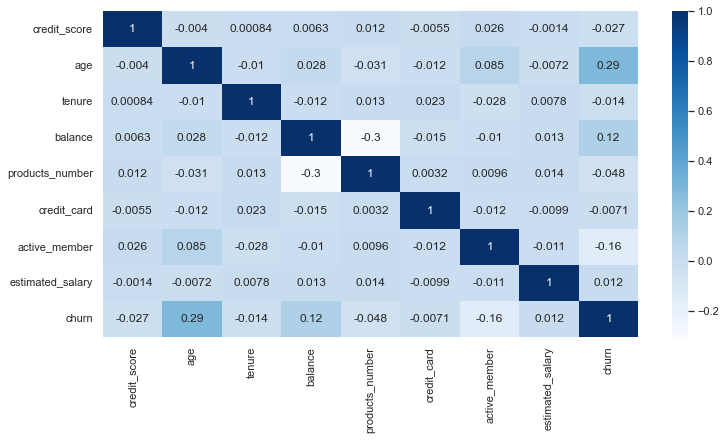

In [359]:
corr = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, cmap="Blues",annot=True)
plt.show()

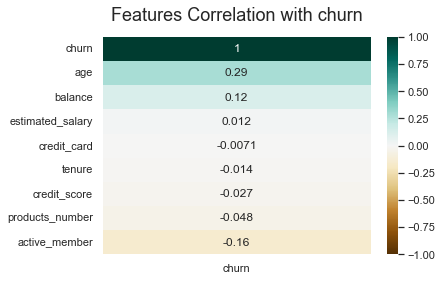

In [360]:
# Features correlation with target variable
heatmap = sns.heatmap(df.corr()[['churn']].sort_values(by='churn', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlation with churn', fontdict={'fontsize':18}, pad=16);

#### Correlation matrix

In [361]:
corr=df.corr()
corr.style.background_gradient(cmap='coolwarm')

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
credit_score,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
products_number,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
credit_card,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
active_member,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
churn,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


#### The highest correlations that we can see from this matrix is between:
* churn and age, 
* churn and balance,
* products_number and balance


#### Correlations and Regplot method in seaborn:

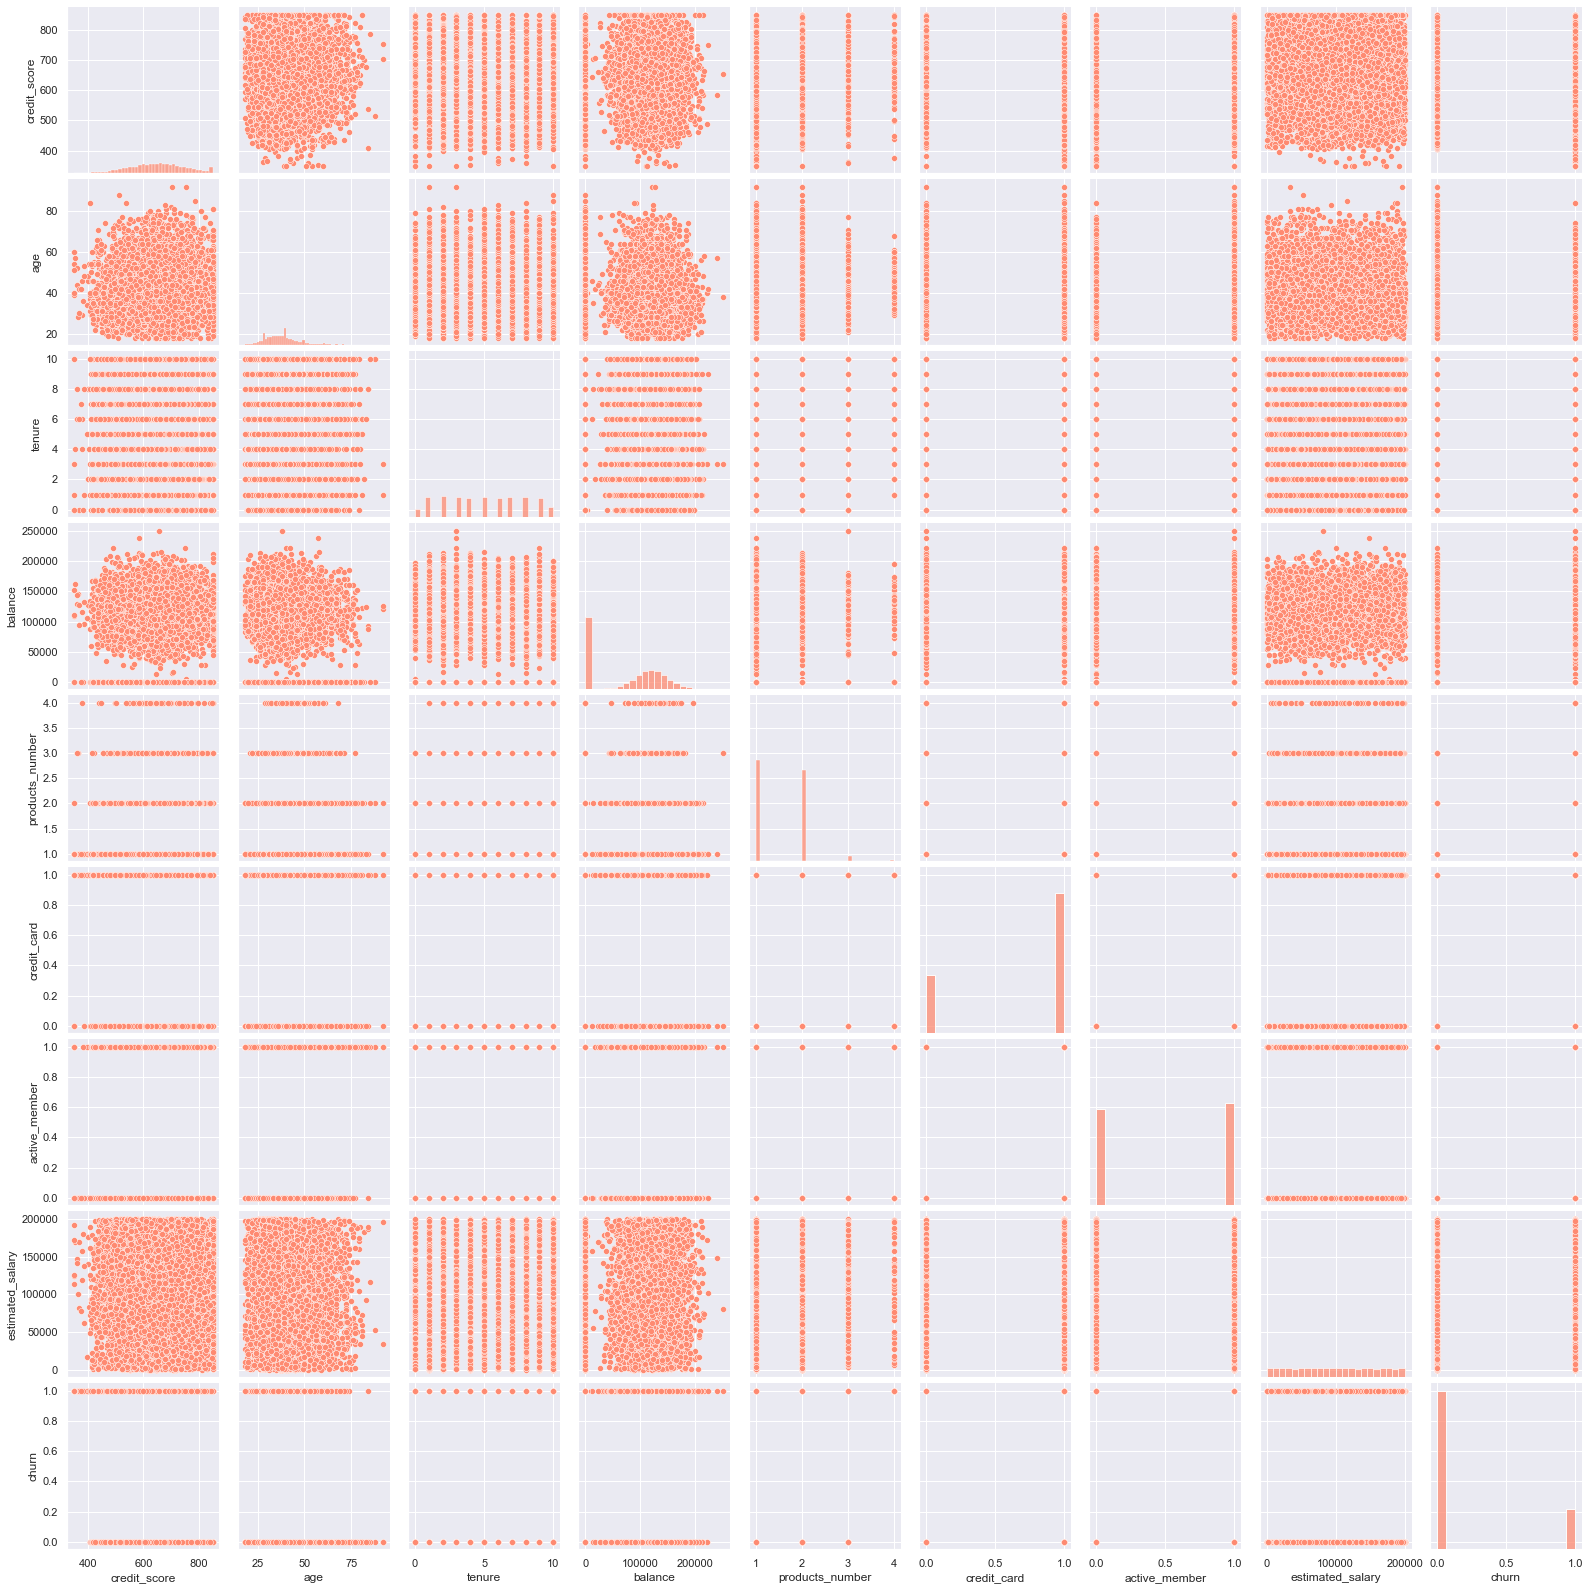

In [362]:
sns.pairplot(df)

> From the plots above, we see that we don't have a linear relationship between any of the variables in our dataset.

### Confidence Intervals

In [363]:
n_samples = len(df['churn']) # size of the sample
k = df['churn'].sum() # churns in the sample
p = k/n_samples  # mean, the estimated proportion.

confidence = 95 # confidence level
q = (confidence + (100 - confidence)/ 2)/ 100  # # 0.975 because Gaussian is symmetric and we need divide 0.05/2
t = stats.t.ppf(q, df=n_samples-1) #t is the quantile such that p(x<=t)= 1-alpha
print(k, p, q, t)

2037 0.2037 0.975 1.9602012636213575


In [364]:
error = t * m.sqrt( (p*(1-p) / n_samples) )
error
lower_bound, upper_bound= p - error, p + error
E = t*((p*(1-p))/n_samples)**(1/2) # margin of error
print(f'error: {round(error,2)}')
print(f'the confidence interval for {confidence} is between {round(lower_bound,2)} and {round(upper_bound,2)}')
print(f'margin error {E}') 

error: 0.01
the confidence interval for 95 is between 0.2 and 0.21
margin error 0.007894680109324127


> With a confidence level of 95% we can say that if we take a new sample of customer, the mean of churn will be between 20% and 21% with a margin of error of 0.78%

## 4. Pre-processing

#### Checking which columns have outliers:

<Figure size 432x288 with 0 Axes>

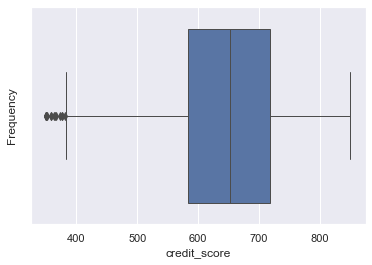

<Figure size 432x288 with 0 Axes>

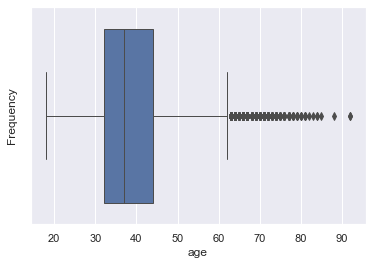

<Figure size 432x288 with 0 Axes>

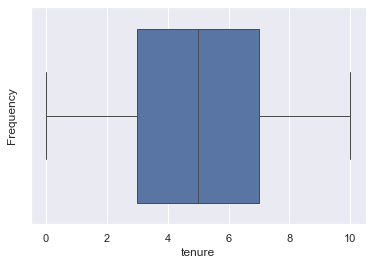

<Figure size 432x288 with 0 Axes>

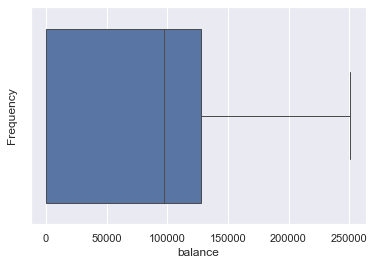

<Figure size 432x288 with 0 Axes>

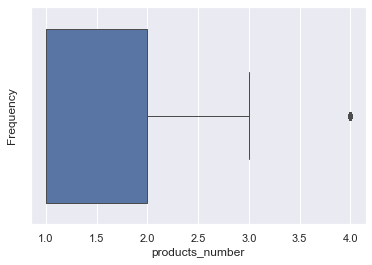

<Figure size 432x288 with 0 Axes>

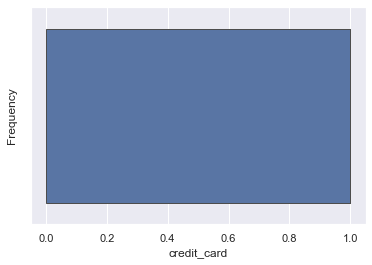

<Figure size 432x288 with 0 Axes>

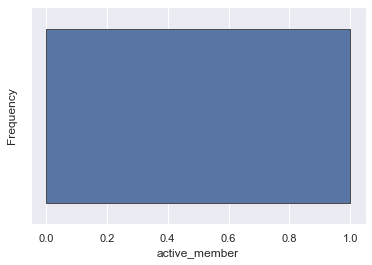

<Figure size 432x288 with 0 Axes>

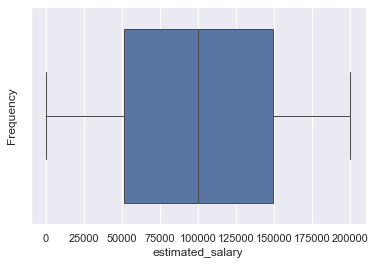

<Figure size 432x288 with 0 Axes>

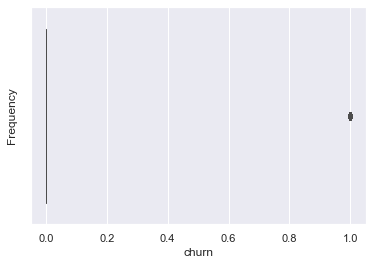

In [365]:
for i in numericals.columns:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(6, 4)})
    f, (ax_box) = plt.subplots(1, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(numericals[i], ax=ax_box , linewidth= 1.0)

#### Removing outliers

In [366]:
Q1 = numericals.quantile(0.25)
Q3 = numericals.quantile(0.75)
IQR = Q3 - Q1

numericals = numericals[~((numericals < (Q1 - 1.5 * IQR)) |(numericals > (Q3 + 1.5 * IQR))).any(axis=1)]

<Figure size 432x288 with 0 Axes>

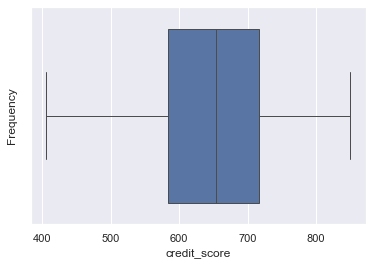

<Figure size 432x288 with 0 Axes>

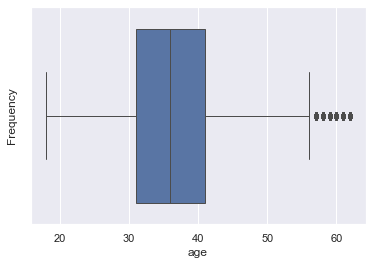

<Figure size 432x288 with 0 Axes>

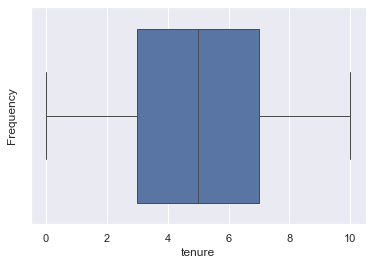

<Figure size 432x288 with 0 Axes>

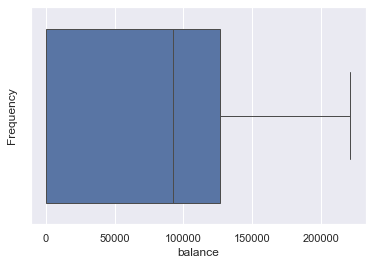

<Figure size 432x288 with 0 Axes>

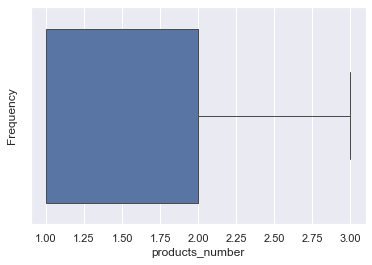

<Figure size 432x288 with 0 Axes>

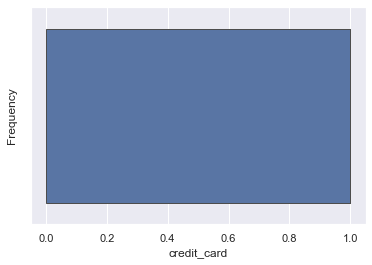

<Figure size 432x288 with 0 Axes>

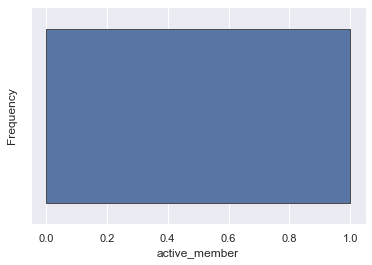

<Figure size 432x288 with 0 Axes>

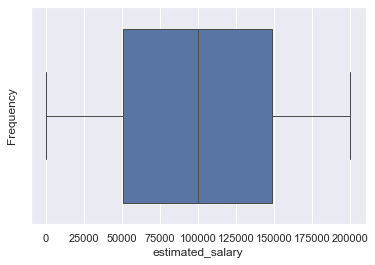

<Figure size 432x288 with 0 Axes>

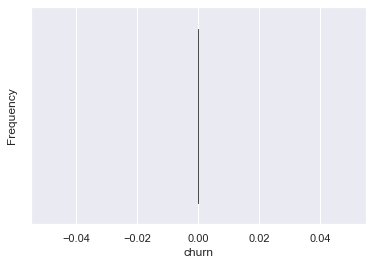

In [367]:
for i in numericals.columns:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(6, 4)})
    f, (ax_box) = plt.subplots(1, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(numericals[i], ax=ax_box , linewidth= 1.0)
    

In [368]:
#ff.show_outlier_col(churn_data,'credit_score')

In [369]:
##ff.show_outlier_col(churn_data,'age')

#### Export Dataset without ouliers

In [370]:
df.to_csv("../data/Bank Customer Churn Prediction without outliers.csv")

### Encoding Categoricals

 * Ordinal Encoder
 * Dummification
 * Label Encoder
 * Onehot Encoder

In [371]:
# Ordinal Encoder
encoder = OrdinalEncoder()

encoder = encoder.fit(df['country'])
df['country'] = encoder.transform(df['country'])

encoder = encoder.fit(df['gender'])
df['gender'] = encoder.transform(df['gender'])

In [372]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,1,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,1,1,42,8,159660.80,3,1,0,113931.57,1
3,699,1,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


### Scalers

In [373]:
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = PolynomialFeatures(degree=2, interaction_only=True) 

# 5. Modelling

> Separating the data (identify Independant features and target)

In [374]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [375]:
#X= df.drop("churn", axis=1)
#y = df["churn"]

Target variable

In [376]:
y.shape

(10000,)

In [377]:
y.value_counts()

0    7963
1    2037
Name: churn, dtype: int64

> we have an imbalance dataset

## Metric

> * Accuracy is not a good Measure for Imbalanced Data. We should not use accuracy when we have imbalanced data
> * F1 Score is the Harmonic Mean of Precision and Recall.
> * The simple mean will treat all values equally, but Harmonic mean gives more weight to low values

#### Split Train and test data set

In [392]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=42)

Check the **distribution of labels**:

In [393]:
pd.DataFrame(y).value_counts(normalize=True)

churn
0        0.7963
1        0.2037
dtype: float64

In [394]:
pd.DataFrame(y_train).value_counts(normalize=True)

churn
0        0.7945
1        0.2055
dtype: float64

In [395]:
pd.DataFrame(y_test).value_counts(normalize=True)

churn
0        0.8035
1        0.1965
dtype: float64

## 5.1 Logistic regression

In [396]:
#Fitting and transforming Data
X_train = scaler3.fit_transform(X_train)
X_test =  scaler3.transform(X_test)

#### managing imbalance dataset

In [397]:
dictionary={0:1, 1:4}

In [398]:
# instantiate the model (using the default parameters)
#logreg = LogisticRegression()   # F1-score 51%

In [399]:
# instantiate the model (with class_weight= dictionary )
logreg = LogisticRegression(class_weight=dictionary, random_state=16)

In [400]:
# fit the model with data
logreg.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1, 1: 4}, random_state=16)

In [401]:
# Predcitions
y_pred = logreg.predict(X_test)

In [402]:
logreg

LogisticRegression(class_weight={0: 1, 1: 4}, random_state=16)

#### Evaluating the results

In [403]:
cnf_matrix = confusion_matrix(y_test, y_pred)
y_train.shape

(8000,)

In [404]:
cnf_matrix

array([[939, 668],
       [118, 275]], dtype=int64)

Text(0.5, 257.44, 'Prediction')

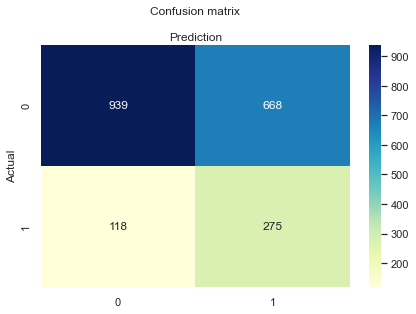

In [405]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Prediction')

#### Classification Report

In [406]:
target_names = ['Churn', 'Not Churn']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Churn       0.89      0.58      0.70      1607
   Not Churn       0.29      0.70      0.41       393

    accuracy                           0.61      2000
   macro avg       0.59      0.64      0.56      2000
weighted avg       0.77      0.61      0.65      2000



In [407]:
print("Train Score : {}".format(logreg.score(X_train, y_train)))
print('Test Score : {}'.format(logreg.score(X_test, y_test)))

Train Score : 0.636375
Test Score : 0.607


> Scaler: PolynomialFeatures
> * Train Score score: 63%
> * Test Score score: 61%
> * F1-score (macro avg): 56%

## 5.2 KNeighborsClassifier

In [408]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=42)

In [410]:
#scaler1 = StandardScaler()
#scaler2 = MinMaxScaler()
#scaler3 = PolynomialFeatures(degree=2, interaction_only=True) 

In [411]:
X_train = scaler2.fit_transform(X_train)
X_test = scaler2.transform(X_test)

In [412]:
# instance of the model using default parameters
#knn= KNeighborsClassifier()  # F1 score = 66%
#knn.fit(X_train,y_train)

In [421]:
# instance of the model with n_neighbors=3
knn= KNeighborsClassifier(n_neighbors=3)  # F1 score = 67%
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [422]:
## predictions on the test set
# y= f(X)
y_pred = knn.predict(X_test)

In [423]:
# accuracy of the model on the test set
accuracy_score(y_test, y_pred)

0.818

In [424]:
y_test.value_counts()

0    1607
1     393
Name: churn, dtype: int64

In [425]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1607
           1       0.55      0.39      0.46       393

    accuracy                           0.82      2000
   macro avg       0.71      0.66      0.67      2000
weighted avg       0.80      0.82      0.81      2000



In [426]:
print("Train Score : {}".format(knn.score(X_train, y_train)))
print('Test Score : {}'.format(knn.score(X_test, y_test)))

Train Score : 0.89075
Test Score : 0.818


> Scaler: MinMaxScaler
> * Train Score score: 89%
> * Test Score score: 82%
> * F1-score (macro avg): 67%

Maximum accuracy:  0.828  at K  8


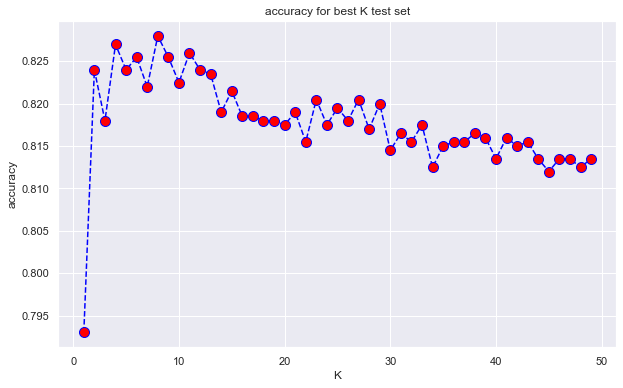

In [419]:
# check visually how to choose K with accuracy test set
#accuracy=[.., ..., ..., ..., ..., ]
accuracy=[]

for neighbor in range(1,50):
    knn= KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    
    
plt.figure(figsize=(10,6))
plt.plot(range(1,50), accuracy, color="blue", linestyle="dashed",
         marker = "o", markerfacecolor="red", markersize=10)
plt.title("accuracy for best K test set")
plt.xlabel("K")
plt.ylabel("accuracy")
print("Maximum accuracy: ", max(accuracy), " at K ", accuracy.index(max(accuracy))+1)
      

Maximum f1score:  0.8051478387762292  at K = 3


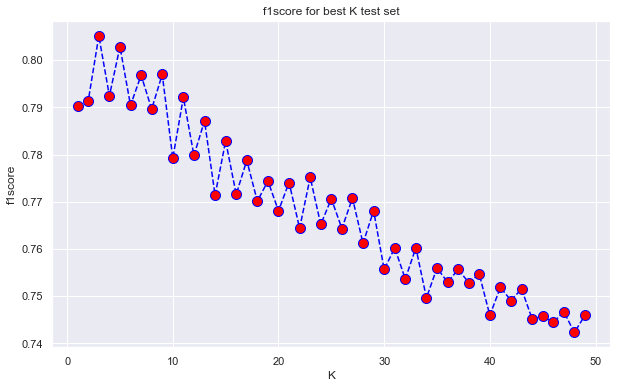

In [420]:
#f1 score on the test set

f1score=[]

for neighbor in range(1,50):
    knn= KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    f1score.append(f1_score(y_test, y_pred, average='weighted'))
    
    
plt.figure(figsize=(10,6))
plt.plot(range(1,50), f1score, color="blue", linestyle="dashed",
         marker = "o", markerfacecolor="red", markersize=10)
plt.title("f1score for best K test set")
plt.xlabel("K")
plt.ylabel("f1score")
print("Maximum f1score: ", max(f1score), " at K =", f1score.index(max(f1score))+1)

## 5.3 Decision Trees

In [427]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [428]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=42)

> Decision Trees model doesn't need scale the features

In [429]:
#### managing imbalance dataset
dictionary={0:1, 1:4}

In [430]:
# min_samples_leaf=50 allows to have more elements in the leaves, so less nodes and the tree is shallower.
classifier = DecisionTreeClassifier(min_samples_leaf=50, class_weight=dictionary)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 4}, min_samples_leaf=50)

>  The min_samples_leaf parameter gives the minimum number of samples in a leaf node.  
They allow to put constraints on the construction of the tree.  
=> Indirectly control the overlearning phenomenon.

After fitting, it is possible to check how many depth levels were used with `.get_depth()` (if not specified as hyperparameter):

In [431]:
classifier.get_depth()

14

#### Evaluation of the quality of the model.

In [432]:
y_pred = classifier.predict(X_test)

In [433]:
accuracy_train = classifier.score(X_train, y_train)
print(f"Accuracy on the training set: {accuracy_train:.0%}")

Accuracy on the training set: 79%


In [434]:
accuracy_test = classifier.score(X_test, y_test)
print(f"Accuracy on the test set: {accuracy_test:.0%}")

Accuracy on the test set: 77%


Check the confusion matrix:

In [435]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[1244,  363],
       [  91,  302]], dtype=int64)

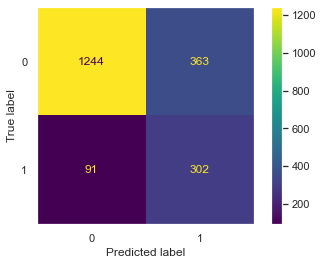

In [436]:
fig, ax = plt.subplots(constrained_layout=False)
plot_confusion_matrix(classifier, X_test, y_test, ax=ax)
ax.grid(b=False);

Get the classification report:

In [437]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.77      0.85      1607
           1       0.45      0.77      0.57       393

    accuracy                           0.77      2000
   macro avg       0.69      0.77      0.71      2000
weighted avg       0.84      0.77      0.79      2000



> * Train Score score: 79%
> * Test Score score: 77%
> * F1-score (macro avg): 71%

Predict the probabilities of each label for new data with `.predict_proba()`:

In [438]:
y_classifier_probabilities = classifier.predict_proba(X_test)

In [439]:
y_classifier_probabilities[:10]

array([[0.71428571, 0.28571429],
       [1.        , 0.        ],
       [0.43307087, 0.56692913],
       [0.80645161, 0.19354839],
       [0.69230769, 0.30769231],
       [1.        , 0.        ],
       [0.62352941, 0.37647059],
       [0.35403727, 0.64596273],
       [0.63909774, 0.36090226],
       [0.15555556, 0.84444444]])

### Visualizing the tree

In [440]:
feature_names = X.columns
class_names = ['Yes', 'No']

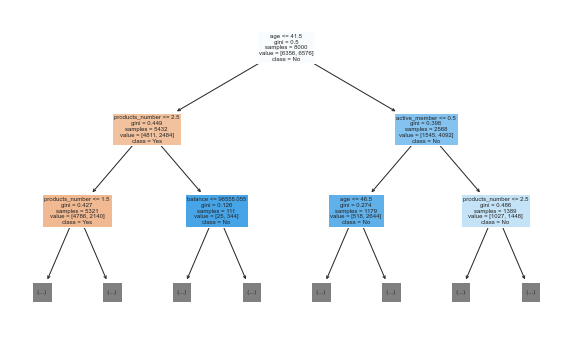

In [441]:
fig = plt.figure(figsize=(10,6))
_ = tree.plot_tree(classifier, 
                   feature_names=X.columns,  
                   class_names=class_names,
                   max_depth=2,
                   filled=True)

In [442]:
text_representation = tree.export_text(classifier)
print(text_representation)

|--- feature_3 <= 41.50
|   |--- feature_6 <= 2.50
|   |   |--- feature_6 <= 1.50
|   |   |   |--- feature_1 <= 2.50
|   |   |   |   |--- feature_5 <= 75122.84
|   |   |   |   |   |--- feature_3 <= 30.50
|   |   |   |   |   |   |--- feature_3 <= 27.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_3 >  27.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_3 >  30.50
|   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |--- feature_2 <= 1.50
|   |   |   |   |   |   |   |   |--- feature_0 <= 653.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_0 >  653.00
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- feature_2 >  1.50
|   |   |   |   |   |   |   |   |--- feature_9 <= 100000.32
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- feature_9 >  100000.32
|   |   |   |   |   |   |   |   |   |--

## Feature Importance

The model also contains **an estimation** of the feature importances (`.feature_importances_`):

In [443]:
classifier.feature_importances_

array([0.01831477, 0.03998031, 0.01574975, 0.4149926 , 0.00551894,
       0.13150373, 0.26747952, 0.00207711, 0.07720913, 0.02717414])

We use the tree to calculate the feature importances without normalization (`.compute_feature_importances(normalize=False)`):

We plot the `feature_importances_` (based on mean decrease in impurity):

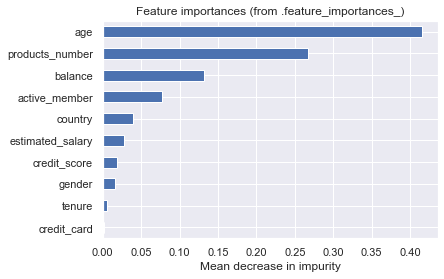

In [444]:
fig, ax = plt.subplots()

feature_importances = classifier.feature_importances_
feature_names = X.columns
dt_feature_importances = pd.Series(feature_importances, index=feature_names)
dt_feature_importances = dt_feature_importances.sort_values()
dt_feature_importances.plot.barh(ax=ax)

ax.set_title("Feature importances (from .feature_importances_)")
ax.set_xlabel("Mean decrease in impurity");

## 5.4 Random Forest

In [445]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [446]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=42)

> Decision Trees model doesn't need scale the features

In [447]:
#### managing imbalance dataset
dictionary={0:1, 1:4}

In [448]:
# Creating a random forest classifier
classifier = RandomForestClassifier(n_estimators=200, class_weight=dictionary)
classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 4}, n_estimators=200)

In [449]:
print("Train Score : {}".format(classifier.score(X_train, y_train)))
print('Test Score : {}'.format(classifier.score(X_test, y_test)))

Train Score : 1.0
Test Score : 0.869


### Evaluation of the quality of the model.

#### Predict the label for new data

In [450]:
y_pred = classifier.predict(X_test)

In [451]:
accuracy_train = classifier.score(X_train, y_train)
print(f"Accuracy on the training set: {accuracy_train:.0%}")

Accuracy on the training set: 100%


In [452]:
accuracy_test = classifier.score(X_test, y_test)
print(f"Accuracy on the test set: {accuracy_test:.0%}")

Accuracy on the test set: 87%


Check the confusion matrix:

In [453]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[1555,   52],
       [ 210,  183]], dtype=int64)

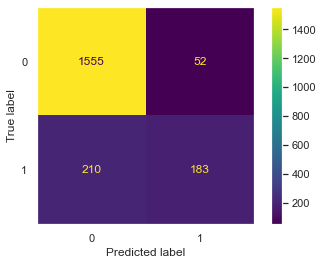

In [454]:
fig, ax = plt.subplots(constrained_layout=False)
plot_confusion_matrix(classifier, X_test, y_test, ax=ax)
ax.grid(b=False);

Get the classification report:

In [455]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.78      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.75      2000
weighted avg       0.86      0.87      0.86      2000



> Scaler: MinMaxScaler
> * Train Score score: 100%
> * Test Score score: 87%
> * F1-score (macro avg): 75%

Predict the probabilities of each label for new data with `.predict_proba()`:

In [456]:
y_classifier_probabilities = classifier.predict_proba(X_test)

In [457]:
y_classifier_probabilities[:10]

array([[0.965, 0.035],
       [0.99 , 0.01 ],
       [0.73 , 0.27 ],
       [0.935, 0.065],
       [0.89 , 0.11 ],
       [1.   , 0.   ],
       [0.865, 0.135],
       [0.765, 0.235],
       [0.81 , 0.19 ],
       [0.735, 0.265]])

## Feature Importance

In [458]:
classifier.feature_importances_

array([0.13241499, 0.04537906, 0.02099019, 0.25300674, 0.07807974,
       0.14243301, 0.13274044, 0.01836433, 0.0371693 , 0.1394222 ])

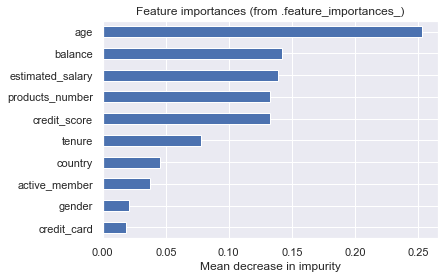

In [459]:
fig, ax = plt.subplots()

feature_importances = classifier.feature_importances_
feature_names = X.columns
dt_feature_importances = pd.Series(feature_importances, index=feature_names)
dt_feature_importances = dt_feature_importances.sort_values()
dt_feature_importances.plot.barh(ax=ax)

ax.set_title("Feature importances (from .feature_importances_)")
ax.set_xlabel("Mean decrease in impurity");

## Model Selection

Based on F1-Score metric, We choose the model with the highest value: "Random Forest Classifier" model with F1- Score = 75%